## Logisitic Regression Analysis

### IMPORTS, INITIALIZE SPARK SESSION AND LOAD CLEANED DATA

In [20]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, lit
import seaborn as sns
import matplotlib.pyplot as plt


# Initialize Spark Session
spark = (SparkSession.builder
         .appName("Collision_Victim_Analysis")
         .config("spark.executor.memory", "4g")  # Increase executor memory
         .config("spark.executor.cores", "2")  # Number of cores per executor
         .config("spark.driver.memory", "4g")  # Increase driver memory
         .getOrCreate())
# Load cleaned collision data
collision_df = spark.read.csv("clean_collision_records.csv", header=True, inferSchema=True)

# Load cleaned victim data
victim_df = spark.read.csv("clean_victim_records.csv", header=True, inferSchema=True)

# Verify loaded data
collision_df.show(5)
victim_df.show(5)


24/12/17 12:40:17 WARN Utils: Your hostname, Seans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 10.0.0.158 instead (on interface en0)
24/12/17 12:40:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/17 12:40:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|           CASE_ID|ACCIDENT_YEAR|PROC_DATE|JURIS|COLLISION_DATE|COLLISION_TIME|OFFICER_ID|REPORTING_DISTRICT|DAY_OF_WEEK|POPULATION|CNTY_CITY_LOC|BEAT_TYPE|CHP_BEAT_TYPE|     PRIMARY_RD|   SECONDARY_RD|DISTANCE|DIRECTION|INTERSECTION|
+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|100010101011401155|         2001| 20010416| 0100|      20010101|           114|      1155|                 0|          1|         4|          198|        0|            0|      DUBLIN BL|    SCARLETT CT|     267|        W|           N|
|100010103174503131|         2001| 20010416| 0100|      

+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|           CASE_ID|ACCIDENT_YEAR|PROC_DATE|JURIS|COLLISION_DATE|COLLISION_TIME|OFFICER_ID|REPORTING_DISTRICT|DAY_OF_WEEK|POPULATION|CNTY_CITY_LOC|BEAT_TYPE|CHP_BEAT_TYPE|     PRIMARY_RD|   SECONDARY_RD|DISTANCE|DIRECTION|INTERSECTION|
+------------------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+---------------+---------------+--------+---------+------------+
|100010101011401155|         2001| 20010416| 0100|      20010101|           114|      1155|                 0|          1|         4|          198|        0|            0|      DUBLIN BL|    SCARLETT CT|     267|        W|           N|
|100010103174503131|         2001| 20010416| 0100|      

### Join the two cleaned datasets (collision record and victim records), create binary target variable for regression

In [23]:

from pyspark.sql.functions import when

# Join the datasets on CASE_ID
combined_df = collision_df.join(victim_df, "CASE_ID", "inner")


# Show the joined data
combined_df.show(5)
print("Total records after join:", combined_df.count())

# change victim degree of injury to binary values
combined_df = combined_df.withColumn("INJURY_SEVERITY_BINARY", when((combined_df["VICTIM_DEGREE_OF_INJURY"] == 1) | (combined_df["VICTIM_DEGREE_OF_INJURY"] == 2), 1).otherwise(0))

# drop reporting district column - unused
cols_to_drop = ['REPORTING_DISTRICT']
combined_df = combined_df.drop(*cols_to_drop)




+-------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+----------+------------+--------+---------+------------+------------+-----------+----------+----------+-----------------------+-----------------------+--------------------+--------------------+--------------+
|CASE_ID|ACCIDENT_YEAR|PROC_DATE|JURIS|COLLISION_DATE|COLLISION_TIME|OFFICER_ID|REPORTING_DISTRICT|DAY_OF_WEEK|POPULATION|CNTY_CITY_LOC|BEAT_TYPE|CHP_BEAT_TYPE|PRIMARY_RD|SECONDARY_RD|DISTANCE|DIRECTION|INTERSECTION|PARTY_NUMBER|VICTIM_ROLE|VICTIM_SEX|VICTIM_AGE|VICTIM_DEGREE_OF_INJURY|VICTIM_SEATING_POSITION|VICTIM_SAFETY_EQUIP1|VICTIM_SAFETY_EQUIP2|VICTIM_EJECTED|
+-------+-------------+---------+-----+--------------+--------------+----------+------------------+-----------+----------+-------------+---------+-------------+----------+------------+--------+---------+------------+------------+-----------+----------+----------

Total records after join: 18710630


### Encode categorical columns for use in logistic regression model

In [11]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline

# Categorical columns to encode
encoded_columns = ["VICTIM_DEGREE_OF_INJURY","VICTIM_SEATING_POSITION","VICTIM_SAFETY_EQUIP1","VICTIM_SAFETY_EQUIP2","VICTIM_EJECTED", "DIRECTION", "INTERSECTION", "DAY_OF_WEEK"]

# Index and encode categorical columns
indexers = [StringIndexer(inputCol=c, outputCol=c+"_index", handleInvalid='skip') for c in encoded_columns]
encoders = [OneHotEncoder(inputCol=c+"_index", outputCol=c+"_vec") for c in encoded_columns]

# Assemble features into a single column
#feature_columns = ["DAY_OF_WEEK", "COLLISION_TIME", "VICTIM_AGE", "VICTIM_SEX", "DIRECTION_vec"]

# Create the assembler
#assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Combine all transformations into a Pipeline
encoded_pipeline = Pipeline(stages=indexers + encoders)

# Transform the data
encoded_df = encoded_pipeline.fit(combined_df).transform(combined_df)

encoded_df.show(5, truncate=False)


# Select final features and target
#final_df = prepared_df.select("features", "VICTIM_DEGREE_OF_INJURY_index")

# Show the resulting DataFrame
#final_df.show(5, truncate=False)


+-------+-------------+---------+-----+--------------+--------------+----------+-----------+----------+-------------+---------+-------------+----------+------------+--------+---------+------------+------------+-----------+----------+----------+-----------------------+-----------------------+--------------------+--------------------+--------------+----------------------+-----------------------------+-----------------------------+--------------------------+--------------------------+--------------------+---------------+------------------+-----------------+---------------------------+---------------------------+------------------------+------------------------+------------------+-------------+----------------+---------------+
|CASE_ID|ACCIDENT_YEAR|PROC_DATE|JURIS|COLLISION_DATE|COLLISION_TIME|OFFICER_ID|DAY_OF_WEEK|POPULATION|CNTY_CITY_LOC|BEAT_TYPE|CHP_BEAT_TYPE|PRIMARY_RD|SECONDARY_RD|DISTANCE|DIRECTION|INTERSECTION|PARTY_NUMBER|VICTIM_ROLE|VICTIM_SEX|VICTIM_AGE|VICTIM_DEGREE_OF_INJURY

### Final check for null rows, drop them if they exist

In [12]:
print("Columns in Combined DataFrame:")
print(combined_df.columns)

print("Columns in Encoded DataFrame:")
print(encoded_df.columns)

print("number of records in Encoded DataFrame:", encoded_df.count())
encoded_df = encoded_df.dropna()



print("number of records in Encoded DataFrame:", encoded_df.count())





Columns in Combined DataFrame:
['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE', 'COLLISION_TIME', 'OFFICER_ID', 'DAY_OF_WEEK', 'POPULATION', 'CNTY_CITY_LOC', 'BEAT_TYPE', 'CHP_BEAT_TYPE', 'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION', 'PARTY_NUMBER', 'VICTIM_ROLE', 'VICTIM_SEX', 'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY', 'VICTIM_SEATING_POSITION', 'VICTIM_SAFETY_EQUIP1', 'VICTIM_SAFETY_EQUIP2', 'VICTIM_EJECTED', 'INJURY_SEVERITY_BINARY']
Columns in Encoded DataFrame:
['CASE_ID', 'ACCIDENT_YEAR', 'PROC_DATE', 'JURIS', 'COLLISION_DATE', 'COLLISION_TIME', 'OFFICER_ID', 'DAY_OF_WEEK', 'POPULATION', 'CNTY_CITY_LOC', 'BEAT_TYPE', 'CHP_BEAT_TYPE', 'PRIMARY_RD', 'SECONDARY_RD', 'DISTANCE', 'DIRECTION', 'INTERSECTION', 'PARTY_NUMBER', 'VICTIM_ROLE', 'VICTIM_SEX', 'VICTIM_AGE', 'VICTIM_DEGREE_OF_INJURY', 'VICTIM_SEATING_POSITION', 'VICTIM_SAFETY_EQUIP1', 'VICTIM_SAFETY_EQUIP2', 'VICTIM_EJECTED', 'INJURY_SEVERITY_BINARY', 'VICTIM_DEGREE_OF_INJURY_index', 

number of records in Encoded DataFrame: 18710617


number of records in Encoded DataFrame: 18710613


/Users/seantan88/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


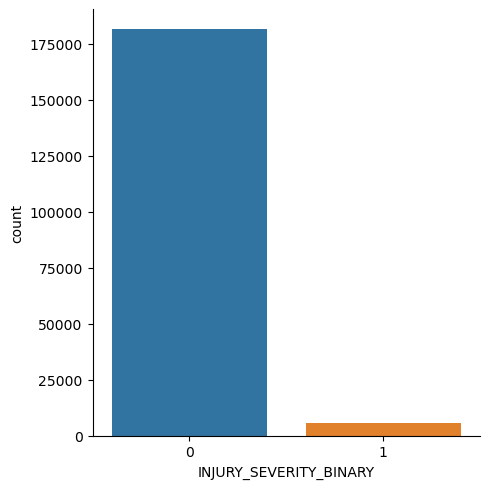

In [24]:
# sample the df since original df is too large to convert to pandas df and plot
sample_df = combined_df.sample(fraction=0.01, seed=6198)

# plot injury severity binary distribution to visualize imbalance
sns.catplot(x="INJURY_SEVERITY_BINARY", kind="count", data=sample_df.toPandas())

### Logisitic Regression model

In [13]:
from pyspark.ml.classification import LogisticRegression
# Create a Logistic Regression model to predict injury severity (1 is fatal/severe, 0 is non-fatal/non-severe), and assemble the features into a single column
logistic_assembler = VectorAssembler(inputCols=["VICTIM_SEATING_POSITION_vec","VICTIM_SAFETY_EQUIP1_vec" ,"VICTIM_SAFETY_EQUIP2_vec", "VICTIM_EJECTED_vec", "DAY_OF_WEEK_vec", "INTERSECTION_vec", "DIRECTION_vec"], outputCol="features")
log_output = logistic_assembler.transform(encoded_df)
total_count = log_output.count()


## Correct the imbalance in the dataset (injury severity binary) 
# Calculate class weights
class_1_count = log_output.filter(col("INJURY_SEVERITY_BINARY") == 1).count()
class_0_count = log_output.filter(col("INJURY_SEVERITY_BINARY") == 0).count()
weight_for_class_1 = total_count / (2 * class_1_count)
weight_for_class_0 = total_count / (2 * class_0_count)

print("Weight for Class 1 (Minority):", weight_for_class_1)
print("Weight for Class 0 (Majority):", weight_for_class_0)

# Add the class weights to the DataFrame
log_output = log_output.withColumn(
    "weight",
    when(col("INJURY_SEVERITY_BINARY") == 1, lit(weight_for_class_1))
    .otherwise(lit(weight_for_class_0))
)


# refine the data to only include relevant columns
log_reg1_data = log_output.select("features", "INJURY_SEVERITY_BINARY", "weight")
log_reg1_data.show(5)


# Split the data into training and test sets
train_data, test_data = log_reg1_data.randomSplit([0.7, 0.3], seed=7122)



# fit the model
log_reg1 = LogisticRegression(labelCol="INJURY_SEVERITY_BINARY", featuresCol="features", weightCol="weight")
log_reg1_model = log_reg1.fit(train_data)

# print summaries
log_reg1_summary = log_reg1_model.summary
log_reg1_summary.predictions.show(5)
log_reg1_summary.predictions.describe().show()






Weight for Class 1 (Minority): 15.999142350933239
Weight for Class 0 (Majority): 0.5161299247622528


+--------------------+----------------------+------------------+
|            features|INJURY_SEVERITY_BINARY|            weight|
+--------------------+----------------------+------------------+
|(96,[1,29,47,71,8...|                     0|0.5161299247622528|
|(96,[2,29,47,71,8...|                     0|0.5161299247622528|
|(96,[0,19,47,71,8...|                     0|0.5161299247622528|
|(96,[1,19,47,71,8...|                     0|0.5161299247622528|
|(96,[1,29,47,71,8...|                     0|0.5161299247622528|
+--------------------+----------------------+------------------+
only showing top 5 rows



+--------------------+----------------------+------------------+--------------------+--------------------+----------+
|            features|INJURY_SEVERITY_BINARY|            weight|       rawPrediction|         probability|prediction|
+--------------------+----------------------+------------------+--------------------+--------------------+----------+
|(96,[0,18,46,71,8...|                   0.0|0.5161299247622528|[1.47936518934381...|[0.81447667716005...|       0.0|
|(96,[0,18,46,71,8...|                   0.0|0.5161299247622528|[1.47936518934381...|[0.81447667716005...|       0.0|
|(96,[0,18,46,71,8...|                   0.0|0.5161299247622528|[1.47936518934381...|[0.81447667716005...|       0.0|
|(96,[0,18,46,71,8...|                   0.0|0.5161299247622528|[1.47936518934381...|[0.81447667716005...|       0.0|
|(96,[0,18,46,71,8...|                   0.0|0.5161299247622528|[1.47936518934381...|[0.81447667716005...|       0.0|
+--------------------+----------------------+-----------

+-------+----------------------+------------------+-------------------+
|summary|INJURY_SEVERITY_BINARY|            weight|         prediction|
+-------+----------------------+------------------+-------------------+
|  count|              13100117|          13100117|           13100117|
|   mean|   0.03125804143581313|1.0000985687211337| 0.2733616806628521|
| stddev|   0.17401430571339424|2.6942656576919903|0.44568496426386445|
|    min|                   0.0|0.5161299247622528|                0.0|
|    max|                   1.0|15.999142350933239|                1.0|
+-------+----------------------+------------------+-------------------+



In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate the Logistic Regression model
log_reg1_evaluator = BinaryClassificationEvaluator(labelCol="INJURY_SEVERITY_BINARY", rawPredictionCol="prediction")
log_reg1_auc = log_reg1_evaluator.evaluate(log_reg1_summary.predictions)

print("Logistic Regression AUC: ", log_reg1_auc)


Logistic Regression AUC:  0.7854533784103546


### Hyperparameter Tuning

In [17]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# create a ParamGrid for hyperparameter tuning
paramGrid = (ParamGridBuilder()
             .addGrid(log_reg1.regParam, [0.001, 0.01, 0.1])
             .addGrid(log_reg1.elasticNetParam, [0.0, 0.1, 0.2])
             .addGrid(log_reg1.maxIter, [10,20,30])
             .build())


# create 2-fold CrossValidator
cv = CrossValidator(estimator=log_reg1,
                    estimatorParamMaps=paramGrid,
                    evaluator=log_reg1_evaluator,
                    numFolds=3)

# run cross validations
cvModel = cv.fit(train_data)

predictions = cvModel.transform(test_data)
log_reg1_auc_tuned = log_reg1_evaluator.evaluate(predictions)

print("Tuned Logistic Regression AUC: ", log_reg1_auc_tuned)

Tuned Logistic Regression AUC:  0.7850491751549165


### Precision, Recall and Accuracy

In [18]:
best_model = cvModel.bestModel
print("Best regParam:", best_model._java_obj.getRegParam())
print("Best elasticNetParam:", best_model._java_obj.getElasticNetParam())
print("Best maxIter:", best_model._java_obj.getMaxIter())

log_reg1_precision = log_reg1_summary.precisionByLabel
log_reg1_recall = log_reg1_summary.recallByLabel
log_reg_1_accuracy = log_reg1_summary.accuracy


print("Logistic Regression Precision by Label:", log_reg1_precision)
print("Logistic Regression Recall by Label:", log_reg1_recall)
print("Logistic Regression Accuracy:", log_reg_1_accuracy)


Best regParam: 0.001
Best elasticNetParam: 0.0
Best maxIter: 10
Logistic Regression Precision by Label: [0.8108985814557248, 0.7638728647154829]
Logistic Regression Recall by Label: [0.7444837463978956, 0.8264230104228258]
Logistic Regression Accuracy: 0.7854576855474465


### Plots

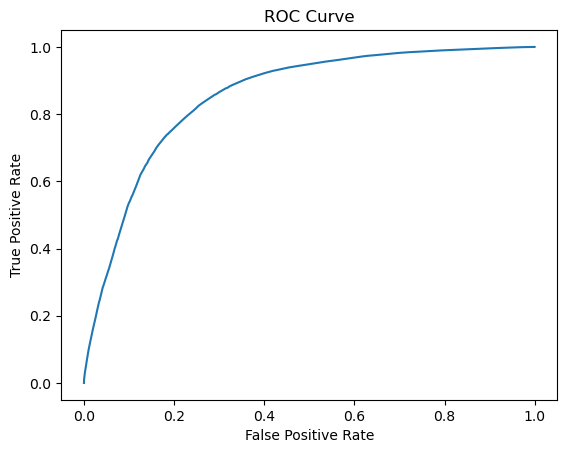

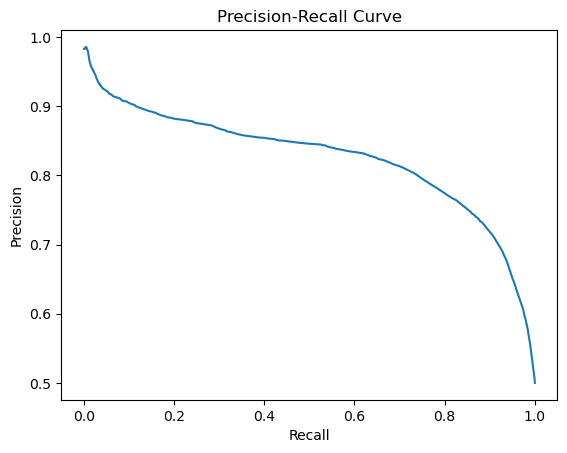

In [29]:
ROC = log_reg1_summary.roc.toPandas()
plt.plot(ROC["FPR"], ROC["TPR"])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

precision = log_reg1_summary.pr.toPandas()
plt.plot(precision["recall"], precision["precision"])
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()


